<a href="https://colab.research.google.com/github/bhagirathtallapragada/Secure-AI-project-phase2/blob/main/privacy_attacks_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this section I implement membership inference attack to evaluate the privacy of a trained model, using tensorflow privacy.

The attack implemented is Threshold attack

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import special
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

The following implementation of the membership inference attacks is heavily based on the following tutorial:
https://www.google.com/url?q=https://franziska-boenisch.de/posts/2021/01/membership-inference/&sa=D&source=hangouts&ust=1638671355428000&usg=AOvVaw2VS8p2Bs0Du0Fv7ymQVDFV

In [2]:
!pip install -U git+https://github.com/tensorflow/privacy

  Cloning https://github.com/tensorflow/privacy to /tmp/pip-req-build-xnmqxwfm
  Running command git clone -q https://github.com/tensorflow/privacy /tmp/pip-req-build-xnmqxwfm
     |████████████████████████████████| 4.0 MB 6.7 MB/s 
  Created wheel for tensorflow-privacy: filename=tensorflow_privacy-0.7.3-py3-none-any.whl size=266056 sha256=ab2ab0e1fc1e8f7d93a9bf3b50b51a76b0bde639a9d41d7fd408b4541d598fe2
  Stored in directory: /tmp/pip-ephem-wheel-cache-5yyw39zf/wheels/a8/64/6f/9c838f8bb45e29d4c0b7b872d965250bed1d9ac89f66953b02
Successfully built tensorflow-privacy
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [3]:
from tensorflow_privacy.privacy.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType

/usr/local/lib/python3.7/dist-packages/tensorflow_privacy/privacy/membership_inference_attack/__init__.py:19: UserWarning: 
Membership inference attack sources were moved. Please replace
import tensorflow_privacy.privacy.membership_inference_attack

with
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack
  "\nMembership inference attack sources were moved. Please replace"


In [4]:
def load_cifar10():
  train, test = tf.keras.datasets.cifar100.load_data()
  train_data, train_labels = train
  test_data, test_labels = test

  # scale the images from color values 0-255 to numbers from 0-1 to help the training process
  train_data = np.array(train_data, dtype=np.float32) / 255
  test_data = np.array(test_data, dtype=np.float32) / 255

  # cifar10 labels come one-hot encoded, there
  train_labels = train_labels.flatten()
  test_labels = test_labels.flatten()

  return train_data, train_labels, test_data, test_labels
 
def make_simple_model():
  shape = (32, 32, 3)
  i = Input(shape=shape)
  x = Conv2D(32, (3, 3), activation='relu')(i)
  x = MaxPooling2D()(x)
  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)
  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)
  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  x = Dense(100)(x)
  model = Model(i, x)
  return model

In [5]:
train_data, train_labels, test_data, test_labels = load_cifar10()

169017344/169001437 [==============================] - 4s 0us/step


In [7]:
model = make_simple_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928 

In [8]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [9]:
# train the model
history = model.fit(train_data, train_labels,
                       validation_data=(test_data, test_labels),
                       batch_size=128, 
                       epochs=30)

Epoch 1/30
391/391 [==============================] - 10s 6ms/step - loss: 4.0563 - accuracy: 0.0829 - val_loss: 3.6736 - val_accuracy: 0.1403
Epoch 2/30
391/391 [==============================] - 2s 5ms/step - loss: 3.4475 - accuracy: 0.1790 - val_loss: 3.3186 - val_accuracy: 0.2055
Epoch 3/30
391/391 [==============================] - 2s 5ms/step - loss: 3.1680 - accuracy: 0.2285 - val_loss: 3.0984 - val_accuracy: 0.2444
Epoch 4/30
391/391 [==============================] - 2s 5ms/step - loss: 2.9828 - accuracy: 0.2642 - val_loss: 2.9715 - val_accuracy: 0.2730
Epoch 5/30
391/391 [==============================] - 2s 5ms/step - loss: 2.8330 - accuracy: 0.2944 - val_loss: 2.8475 - val_accuracy: 0.2986
Epoch 6/30
391/391 [==============================] - 2s 5ms/step - loss: 2.7267 - accuracy: 0.3148 - val_loss: 2.8490 - val_accuracy: 0.2941
Epoch 7/30
391/391 [==============================] - 2s 5ms/step - loss: 2.6223 - accuracy: 0.3378 - val_loss: 2.7772 - val_accuracy: 0.3106
Epoch

(0.0, 1.0)

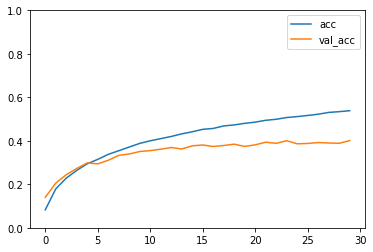

In [10]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend();
plt.ylim(0,1)

In [18]:
print('Predictions on train')
logits_train = model.predict(train_data)
print('Predictions on test')
logits_test = model.predict(test_data)

print('Apply softmax to get probabilities from logits')
prob_train = special.softmax(logits_train, axis=1)
prob_test = special.softmax(logits_test, axis=1)

print('Compute loss')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

y_train_onehot = to_categorical(train_labels)
y_test_onehot = to_categorical(test_labels)

loss_train = cce(constant(y_train_onehot), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(y_test_onehot), constant(prob_test), from_logits=False).numpy()

Predictions on train
Predictions on test
Apply softmax to get probabilities from logits
Compute loss


In [12]:
# define what variables our attacker should have access to
attack_input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = train_labels,
  labels_test = test_labels
)

In [13]:
# how should the data be sliced
slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = True,
    by_percentiles = False,
    by_classification_correctness = True)

In [14]:
# define the type of attacker model that we want to use
attack_types = [
    AttackType.THRESHOLD_ATTACK
]

In [15]:
# run the attack
attacks_result = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types)

In [16]:
print(attacks_result.summary(by_slices=True))

Best-performing attacks over all slices
  THRESHOLD_ATTACK (with 500 training and 100 test examples) achieved an AUC of 0.75 on slice CLASS=98
  THRESHOLD_ATTACK (with 500 training and 100 test examples) achieved an advantage of 0.40 on slice CLASS=98

Best-performing attacks over slice: "Entire dataset"
  THRESHOLD_ATTACK (with 50000 training and 10000 test examples) achieved an AUC of 0.61
  THRESHOLD_ATTACK (with 50000 training and 10000 test examples) achieved an advantage of 0.18

Best-performing attacks over slice: "CLASS=0"
  THRESHOLD_ATTACK (with 500 training and 100 test examples) achieved an AUC of 0.52
  THRESHOLD_ATTACK (with 500 training and 100 test examples) achieved an advantage of 0.12

Best-performing attacks over slice: "CLASS=1"
  THRESHOLD_ATTACK (with 500 training and 100 test examples) achieved an AUC of 0.61
  THRESHOLD_ATTACK (with 500 training and 100 test examples) achieved an advantage of 0.19

Best-performing attacks over slice: "CLASS=2"
  THRESHOLD_ATTAC

Figure(432x288)


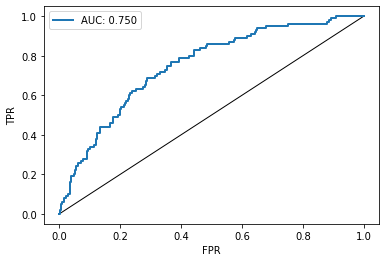

In [17]:
import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting
print(plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve))